# Week 5: GANs Monet Painting Mini-Project

## 1. Introduction
As humans, we possess the innate ability to recognize an artist's style through visual cues in their work. This project seeks to mimic that aesthetic knowledge by transforming ordinary photos into Monet-style paintings using Generative Adversarial Networks (GANs). The GAN framework consists of a generator that creates Monet-style images from photos and a discriminator that attempts to distinguish between real Monet paintings and those generated by the generator. The goal is to train the generator to produce images that are indistinguishable from real Monet paintings, effectively learning the artistic style of Monet and applying it to new photos.

## 2. Exploratory Data Analysis (EDA)
The dataset is stored in TFRecord format, which allows efficient data loading and handling in TensorFlow. This dataset contains two main categories of images: Monet paintings and photos. I begin by loading the images from the TFRecord files and visualizing some samples to better understand the data I'm working with. This section loads the TFRecord files containing Monet paintings and photos, normalizes the images, and prepares them for training. The data is loaded in batches and preprocessed for efficiency during model training.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
import os

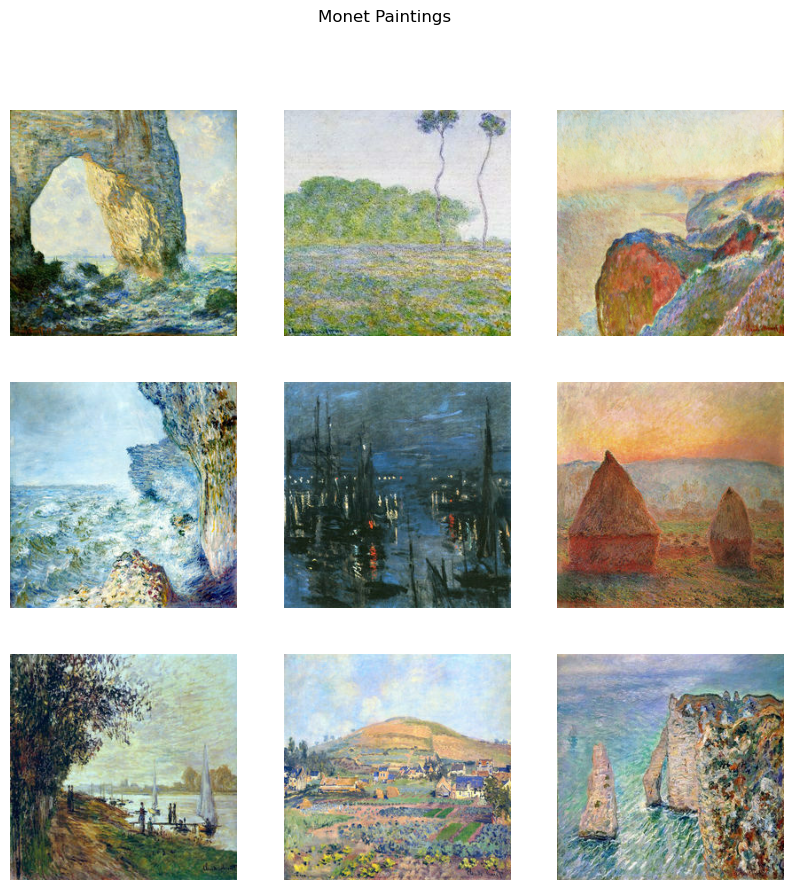

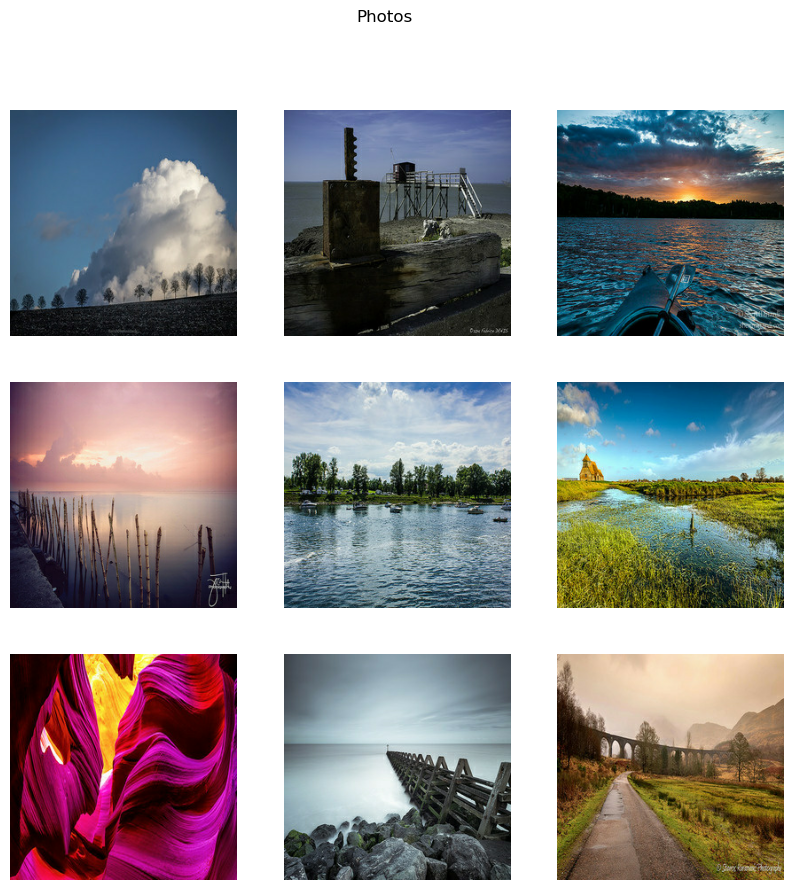

In [2]:
# Load the TFRecord files 
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    return image

def load_dataset(tfrecord_paths, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_paths)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

monet_tfrecords = tf.io.gfile.glob('monet_tfrec/*.tfrec')
photo_tfrecords = tf.io.gfile.glob('photo_tfrec/*.tfrec')

# Load datasets
batch_size = 32
monet_ds = load_dataset(monet_tfrecords, batch_size)
photo_ds = load_dataset(photo_tfrecords, batch_size)

# Visualize some images
def visualize_images(dataset, title):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow((image[0] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize Monet paintings
visualize_images(monet_ds, 'Monet Paintings')

# Visualize Photos
visualize_images(photo_ds, 'Photos')


## 3. Model Building & Training

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(256, 256, 3)))
    model.add(layers.Conv2D(64, (7, 7), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(3, (7, 7), padding='same', activation='tanh'))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(256, 256, 3)))
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    return model

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)


C:\Users\Cecile\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [4]:
# Training
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_monet = generator(real_photo, training=True)
        
        real_output = discriminator(real_monet, training=True)
        fake_output = discriminator(generated_monet, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss = loss_fn(tf.ones_like(real_output), real_output) + \
                    loss_fn(tf.zeros_like(fake_output), fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset_monet, dataset_photo, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for monet_images, photo_images in zip(dataset_monet, dataset_photo):
            train_step(monet_images, photo_images)
        
        print(f'Epoch {epoch + 1}, Time taken: {time.time() - start} seconds')

train(monet_ds, photo_ds, epochs=5)


Epoch 1, Time taken: 7.475523233413696 seconds
Epoch 2, Time taken: 5.896888494491577 seconds
Epoch 3, Time taken: 5.739552021026611 seconds
Epoch 4, Time taken: 5.836334943771362 seconds
Epoch 5, Time taken: 6.02711296081543 seconds


## 4. Generate Results
After training, I generate Monet-style images from the photos and save them using the original filenames.

In [5]:
tfrecord_folder = 'photo_tfrec'
tfrecord_files = [f for f in os.listdir(tfrecord_folder) if f.endswith('.tfrec')]

base_filenames = [os.path.splitext(f)[0] for f in tfrecord_files]

output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

# Generate and save images using base_filenames for naming
for i, (photo_image, base_filename) in enumerate(zip(photo_ds, base_filenames)):
    generated_monet = generator(photo_image, training=False)
    for j, img in enumerate(generated_monet):
        img = (img * 127.5 + 127.5).numpy().astype(np.uint8)
        img = tf.image.encode_jpeg(img)
        # Use base_filenames to name the generated images
        filepath = os.path.join(output_dir, f'{base_filename}.jpg')
        tf.io.write_file(filepath, img)

# Zip the generated images
with zipfile.ZipFile('images.zip', 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

NameError: name 'zipfile' is not defined

## 5. Conclusion
In this project, I implemented a GAN-based approach to transform ordinary photos into Monet-style paintings. Through the training of a generator and discriminator model, the generator learned to produce high-quality, Monet-like images that convincingly mimic the artist's style. After training, I generated and saved these Monet-style images using the original filenames extracted from the TFRecord files. The project demonstrated the effectiveness of GANs in unpaired image-to-image translation.